In [2]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# Exploring Safer Use of Stable Diffusion

This notebook explores two ways of improving the safety of SD:
1. Application of a robotics inspired potential-based "obstacle avoidance" to SD prompt-to-prompt sequence generation.
2. Negative prompting.

## Setup
*You may need to adjust the CUDA devices here. I was OOMing when running SD *and* the `jax` gradient descent-based safety tool, so I tend to run SD and jax computations on separate GPUs.*

In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# adjust this to match which GPUs you want StableDiffusion and Jax to be able to use
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"

In [ ]:
# import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from PIL import Image

import jax
if len(jax.devices("gpu")) >= 3:
    jax.config.update("jax_default_device", jax.devices()[2])
import jax.numpy as jnp

import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

from modded_stable_diffusion import ModdedStableDiffusion
from salve import compute_safe_path, compute, U, grad_U, distance, DistType, UConfig, plot_grid, export_as_gif

As in the `random_walks_with_stable_diffusion.ipynb`, we JIT compile the model and 
use `mixed_float16`. We also will utilize the separate `encode_text` and `generate_image` part of the API as we'll be working with the model's encodings quite a bit.

In [ ]:
# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = ModdedStableDiffusion(jit_compile=True)

Just to make sure the model is working, we'll make a classic image:

In [7]:
prompt =  "an avocado chair. 4k, 8k, unreal engine, octane render, hdr, high definition, volumetric lighting, dusty haze, photo, octane render, 24mm, 4k, 24mm, DSLR, high quality, 60 fps, ultra realistic"
encoding = model.encode_text(prompt)

# Show the size of the latent manifold
print(f"Encoding shape: {encoding.shape}")

Encoding shape: (1, 77, 768)


In [8]:
seed = 64209
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=seed)

100/100 [==============================] - 17s 168ms/step


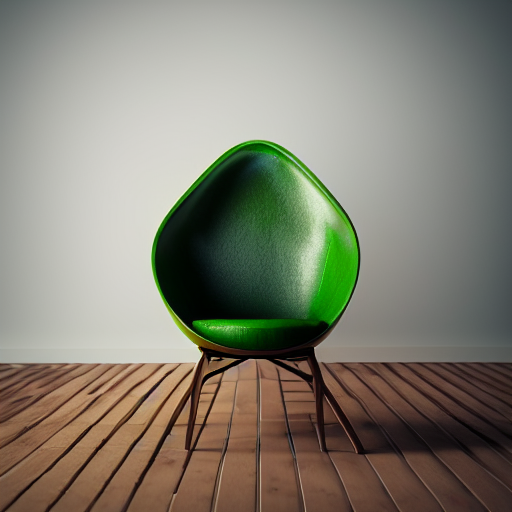

In [10]:
image = model.generate_image(
    encoding,
    diffusion_noise=noise,
    num_steps=100,
    unconditional_guidance_scale=12
)
Image.fromarray(image[0]).show()

## Applying a "Black Box" Obstacle Avoidance "Safety" Filter to SD

Here, we'll be doing some early exploration of how prompt embeddings can be steered using [potential-based planning techniques from robotics](https://www.cs.cmu.edu/~motionplanning/lecture/Chap4-Potential-Field_howie.pdf). Potential based methods are an older motion planning technique that allow one to find paths through spaces that don't collide with obstacles. This is done by creating differentiable potential fields around the goal and obstacle coordinates which allow simple gradient descent to find a collision-free path through the space to the goal. An example of this in 2D:
![](potential_planning_example.png)
is developed in `black_box_SD_safety_toy_example.ipynb`.

We'll be using some pretty standard "high-quality" positive prompting for the model. Adding or removing this can dramatically affect the encodings and thus the distances between different encodings (especially w.r.t. to different distance measures).

In [11]:
aesthetic_garbage = ", 4k, 8k, unreal engine, octane render photorealistic by cosmicwonder, hdr, photography by cosmicwonder, high definition, volumetric lighting, 24mm, high quality, ultra realistic"

In [12]:
encoding = model.encode_text(f"white fluffy cat laying on the floor {aesthetic_garbage}")
goal_encoding = model.encode_text(f"blue striped cat sitting in a box {aesthetic_garbage}")

avoid_encoding_1 = tf.squeeze(model.encode_text(f"blue striped animal sitting on the ground {aesthetic_garbage}"))
avoid_encoding_2 = tf.squeeze(model.encode_text(f"cute tabby cat on the ground {aesthetic_garbage}"))

enc_start = jnp.array(encoding, dtype=jnp.float32)
enc_goal = jnp.array(goal_encoding, dtype=jnp.float32)
enc_obstacles = jnp.array([avoid_encoding_1, avoid_encoding_2], dtype=jnp.float32)

In [13]:
U_config = UConfig(
    obstacle_radius=0.10,
    dist_to_feel_repulsion=0.05,
    gain_attractive=2000.0,
    gain_repulsive=0.1,
    dist_type=DistType.cosine,
    norm_ord=2
)

enc_history = compute_safe_path(
    q_start=enc_start,
    q_goal=enc_goal,
    q_obstacles=enc_obstacles,
    grad_desc_rate=2e-2,
    zero_grad_tol=1e-5,
    random_jitter_mag_cov=1e-4,
    N=int(3e4),
    U_config=U_config,
    show_progbar=True
)
len(enc_history)

29970/30000 [============================>.] - ETA: 0s

30001

In [23]:
dist_kwargs = {"dist_type": U_config.dist_type, "norm_ord": U_config.norm_ord}

print(f"start-goal dist: {distance(enc_start, enc_goal, **dist_kwargs)}")

print("")
print(f"start-obs0 dist: {distance(enc_start, enc_obstacles[0], **dist_kwargs)}")
print(f"start-obs1 dist: {distance(enc_start, enc_obstacles[1], **dist_kwargs)}")

print("")
print(f"goal-obs0 dist: {distance(enc_goal, enc_obstacles[0], **dist_kwargs)}")
print(f"goal-obs1 dist: {distance(enc_goal, enc_obstacles[1], **dist_kwargs)}")

print("")
print(f"final_pos-obs0 dist: {distance(enc_history[-1], enc_obstacles[0], **dist_kwargs)}")
print(f"final_pos-obs1 dist: {distance(enc_history[-1], enc_obstacles[1], **dist_kwargs)}")

print("")
print(f"final_pos-goal dist: {distance(enc_history[-1], enc_goal, **dist_kwargs)}")

start-goal dist: 0.26474517583847046

start-obs0 dist: 0.2752145528793335
start-obs1 dist: 0.43601667881011963

goal-obs0 dist: 0.11481547355651855
goal-obs1 dist: 0.4557400941848755

final_pos-obs0 dist: 0.14925992488861084
final_pos-obs1 dist: 0.42407143115997314

final_pos-goal dist: 0.02843528985977173


In [24]:
downsampling_factor = 20
U_values = compute(
    U,
    jnp.concatenate(enc_history[0 : len(enc_history) : downsampling_factor], axis=0),
    enc_goal,
    enc_obstacles,
    U_config=U_config,
)
px.line(
    x=[i * downsampling_factor for i in list(range(0, len(U_values)))],
    y=U_values,
    labels={"x": "iteration", "y": "Potential Function Value of Embedding - U(embedding)"},
)

Here we can see the starting prompt's image, where we've tuned the `num_steps` and `unconditional_guidance_scale` to make pleasing start/goal images:

100/100 [==============================] - 43s 165ms/step


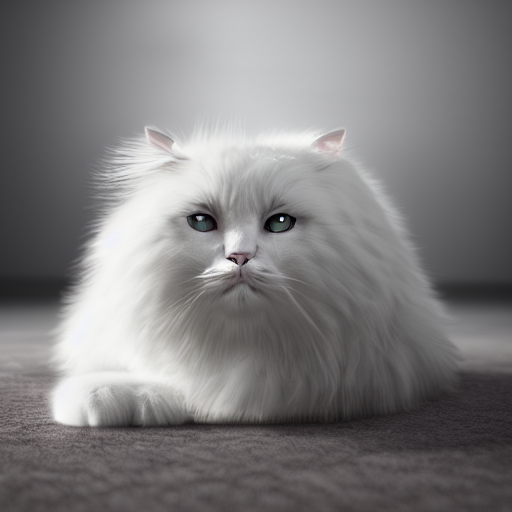

In [16]:
num_steps = 100
unconditional_guidance_scale = 8

image = model.generate_image(
    enc_start,
    diffusion_noise=noise,
    num_steps=num_steps,
    unconditional_guidance_scale=unconditional_guidance_scale,
)
Image.fromarray(image[-1]).show()

Here we can see the "goal" prompt's image:

100/100 [==============================] - 18s 178ms/step


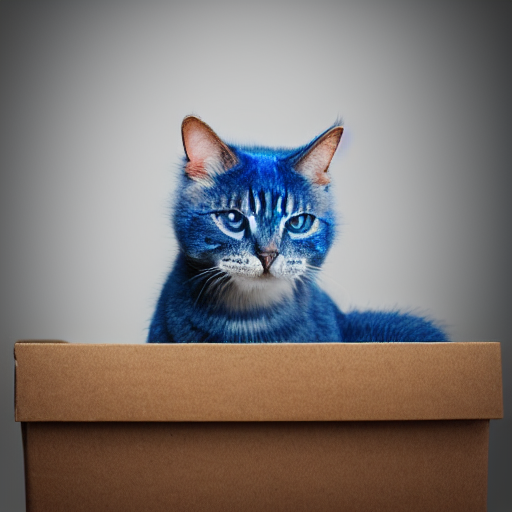

In [30]:
image = model.generate_image(
    enc_goal,
    diffusion_noise=noise,
    num_steps=num_steps,
    unconditional_guidance_scale=unconditional_guidance_scale,
)
Image.fromarray(image[-1]).show()

Here we can see the primary "obstacle" prompt's image:

100/100 [==============================] - 18s 177ms/step


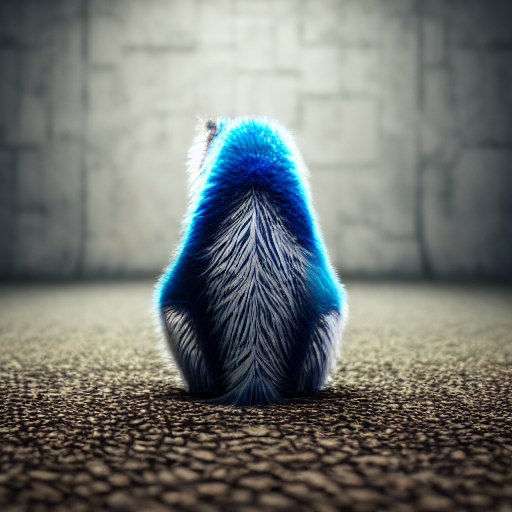

In [31]:
image = model.generate_image(
    enc_obstacles[0],
    diffusion_noise=noise,
    num_steps=num_steps,
    unconditional_guidance_scale=unconditional_guidance_scale,
)
Image.fromarray(image[-1]).show()

Finally, we can see the where the image of the last step of gradient descent, which should be as "close" to the *goal* image as possible while being as "far" as possible from the obstacles:

100/100 [==============================] - 18s 178ms/step


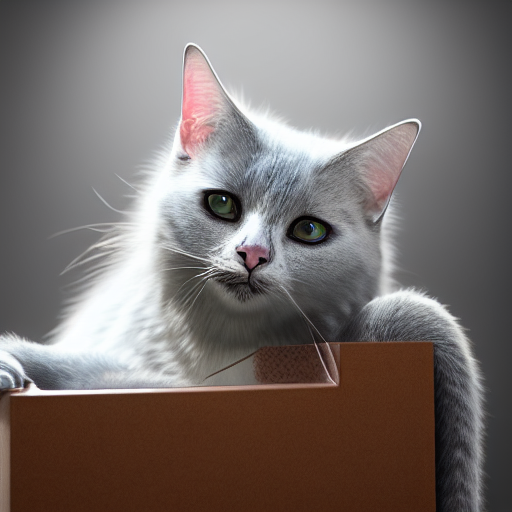

In [32]:
image = model.generate_image(
    enc_history[-1],
    diffusion_noise=noise,
    num_steps=num_steps,
    unconditional_guidance_scale=unconditional_guidance_scale,
)
Image.fromarray(image[-1]).show()

Let's generate a gif so we can see the path we made in the text encoding space. 

*Interestingly*, I find the images that occur before reaching a very small potential towards the end of the path history to be aesthetically better, even though they're further than the final path encoding (as measured by cosine distance) to the goal encoding.

In [23]:
num_images_in_gif = 250
length_of_gif_seconds = 10.0
gif_path = "blue_striped_cat-potential_based_path_2.gif"

step_size = len(enc_history) // num_images_in_gif
checkpointed_images = tf.concat(enc_history[0 : len(enc_history) - 1 : step_size], axis=0)

batch_size = num_images_in_gif // 10
num_batches = len(checkpointed_images) // batch_size
batched_encodings = tf.split(checkpointed_images, num_batches)

In [18]:
images = []
for batch in batched_encodings:
    images.extend(
        model.generate_image(
            batch,
            batch_size=batch_size,
            diffusion_noise=noise,
            num_steps=num_steps,
            unconditional_guidance_scale=unconditional_guidance_scale,
        )
    )

100/100 [==============================] - 89s 894ms/step


In [25]:
def ceiling_division(n, d):
    return -(n // -d)

export_as_gif(
    gif_path,
    [Image.fromarray(img) for img in images],
    frames_per_second=ceiling_division(len(images), length_of_gif_seconds),
    rubber_band=True,
)

In [43]:
from IPython import display

display.HTML(f'<img src="{gif_path}"/>')

In [ ]:
def embed_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

embed_gif(gif_path)

## Negative Prompting

[Negative prompts](https://stable-diffusion-art.com/how-negative-prompt-work/) are a popular method to improve the alignment of diffusion model output that work by modifying the "unconditional" latents used in the diffusion process. The "unconditional" context is built from encoded "negative" text rather than the normal "unconditioned" context, which is fixed to be something like an encoded empty prompt. 

When combined with an `unconditional_guidance_scale` > 1, the negative latents are removed at each diffusion step.

For comparison, we'll use the same "goal" prompt encoding from above and use negative prompting to try to apply the same safety filter to the output.

In [33]:
neg_prompt_garbage = "missing limbs, signs, memes, labels, text, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry, made by children, caricature, lacklustre, cropped, (long neck), body horror, out of frame, mutilated, tiled, frame, border, porcelain skin, doll like"
negative_encoding = model.encode_text(f"blue stripes, blue, {neg_prompt_garbage}")

In [34]:
image_no_negative_prompting = model.generate_image(
    enc_goal,
    diffusion_noise=noise,
    num_steps=num_steps,
    unconditional_guidance_scale=unconditional_guidance_scale,
)

100/100 [==============================] - 18s 178ms/step


In [35]:
image_with_negative_prompting = model.generate_image(
    enc_goal,
    diffusion_noise=noise,
    num_steps=num_steps,
    unconditional_guidance_scale=unconditional_guidance_scale,
    encoded_negative_text=negative_encoding
)

100/100 [==============================] - 18s 179ms/step


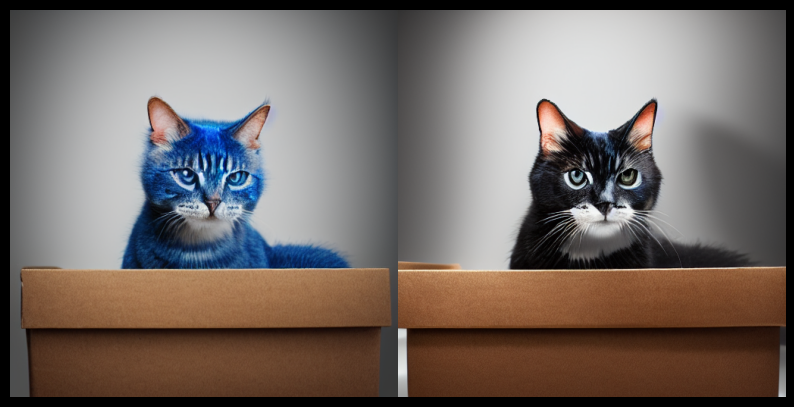

In [36]:
images = np.concatenate([image_no_negative_prompting, image_with_negative_prompting])
_ = plot_grid(images, grid_size=(1,2), path="blue_striped_cat_negative_prompting.png", scale=10)

## Comparison

See the README for a discussion about how these methods compare. Implementing negative prompting seems like a clearer way to enforce some underlying constraints, but it is also not a perfect solution.

## More experimentation with negative prompting

50/50 [==============================] - 12s 237ms/step


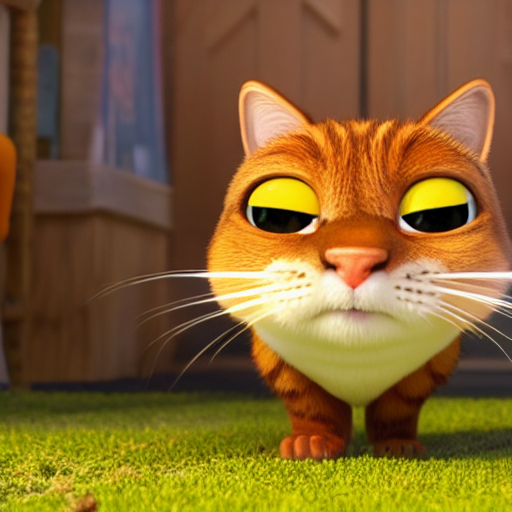

In [186]:
prompt = "Pixar style puss in boots, 4k, 8k, unreal engine, high definition, symmetrical face, volumetric lighting, dusty haze, photo, octane render, 24mm, 4k, 24mm, DSLR, high quality, 60 fps, ultra realistic"
neg_prompt = "black and white, blur, blurry, soft, blush, filter, noise, deformed, defective, incoherent, twisted, extra limbs, extra fingers, poorly drawn hands, messy drawing, poorly composed, out of frame, text, watermark"

encoding = model.encode_text(prompt)
negative_encoding = model.encode_text(neg_prompt)

image = model.generate_image(
    encoding,
    # diffusion_noise=noise,
    num_steps=50,
    unconditional_guidance_scale=8,
    encoded_negative_text=negative_encoding
)
Image.fromarray(image[-1]).show()